# MyMedScribe - A Performant and Reliable AI Medical Scribe

This Jupyter Notebook shows how to evaluate an LLM App unsing 
[Lynxius](https://www.lynxius.ai/) SDK.

The application being under examination is **MyMedScribe**, an AI Medical Scribe that 
assists medical doctors by capturing notes during patient visits. The App workflow 
follows:

1. 🎤 Notes are recorded with the the doctor's smartphone 🎙️
2. 🧠 **MyMedScribe**'s cleaver AI filters out small talk, summarizes content, identifies 
    key medical information and generates clinical documentation 🤖
3. 🩺 The doctor reviews the AI-generated notes and signs off ✅

## The Patient Consultation

* **Brenda Hills** experiences chest pain and seeks medical advice from her physician. 
* Her physician, **Dr. Sara Taylor**, utilizes the **MyMedScribe** App to streamline her 
  documentation process.

For Dr. Taylor, it is imperative that the transcripts and clinical notes produced by 
**MyMedScribe** are of exceptional quality: they need to be accurate, comprehensive, and 
free from any errors, ensuring no vital information is omitted.

<style>
    @media (prefers-color-scheme: dark) {
        .adaptive-text { background-color: #fffb00; } /* Light text in dark theme */
    }
    @media (prefers-color-scheme: light) {
        .adaptive-text { background-color: #fffb00; } /* Dark text in light theme */
    }
</style>

## Jupyter Notebook Setup

This Jupyter notebook requires a small setup to start. We need to import the relevant 
packages and utility functions. To consume [Lynxius Platform](https://platform.lynxius.ai/) 
we need to provide `LYNXIUS_API_KEY` secret key.
Today Lynxius offers OpenAI GPT-4 by default as LLM model for 
evaluation, but we are building our own models for more accurate evaluations.

⚠️⚠️⚠️ <span class="adaptive-text">At the moment Lynxius's OpenAI key is used, but we plan 
to enable also users to use their own keys or directly use our proprietary models. 
</span> ⚠️⚠️⚠️

In [1]:
import os
import sys
from getpass import getpass

from AI_medical_scribe_utils import load_input, load_yaml_input

# Making sure a local version of the Lynxius library is available
sys.path.append("../")


# set Lynxius secret key
if not (lynxius_api_key := os.getenv("LYNXIUS_API_KEY")):
    lynxius_api_key = getpass("🔑 Enter your Lynxius API key: ")

os.environ["LYNXIUS_API_KEY"] = lynxius_api_key

os.environ["LYNXIUS_BASE_URL"] = "https://platform.lynxius.a"

## Task-1: Evaluating Summarization Quality

**MyMedScribe** App filters and summarizes the patient visit and generates a clean 
transcript.

<img src="https://github-public-assets.s3.us-west-1.amazonaws.com/AI_medical_scribe_sumarization.png" alt="AI Medical Scribe summarization" width="60%" />

⚠️⚠️⚠️ **The AI-generated summarization looks good, but... How good is it?** ⚠️⚠️⚠️

**MyMedScribe** team knows how crucial it is to Dr. Taylor that the AI-generated 
transcript contains all the relevant information of the original conversation with 
Brenda. **MyMedScribe** team must evaluate their product before and after deploying it to 
production and chooses [Lynxius](https://www.lynxius.ai/) for testing and evaluating 
their LLM App.

### Missing Information Score

**MyMedScribe** team wants to evaluate the summarization performance of their LLM App. 
They care to know if the AI-generated transcript is semantically similar to the original 
raw transcript recorded by Dr. Taylor's smartphone and if it missing any relevant 
information.

[Lynxius](https://www.lynxius.ai/) `BertScore` evaluator is perfect as the 
**"Missing Information Score"**. It takes the original raw transcript and the 
AI-generated summary as inputs and determines their semanthic similarity.

<img src="https://github-public-assets.s3.us-west-1.amazonaws.com/AI_medical_scribe_eval_sumarization.png" alt="AI Medical Scribe eval summarization" width="60%" />

Let's see the `BertScore` evaluator in action:

In [2]:
# load raw transcript and AI-generated summary
raw_transcript = load_input('./data/AI_medical_scribe_raw.yaml')
ai_summary = load_input('./data/AI_medical_scribe_summary.yaml')

In [3]:
from lynxius.client import LynxiusClient
from lynxius.evals.bert_score import BertScore

client = LynxiusClient()

# Calculate the BertScore and upload results to Lynxius Platform
tags = ["gpt-4o", "MyMedScribeApp", "summarization", "DB:v1"]
bert_score = BertScore("PR #111", level="sentence", presence_threshold=0.65, tags=tags)

# Add traces to the evals
bert_score.add_trace(reference=raw_transcript, output=ai_summary, context=[])

# Run eval remotely
client.evaluate(bert_score)

'12f6bdaf-af36-412f-867c-9477074bc287'

We previously set our Project's Bert Score Thresholds to the following values:

<table>
  <thead style="background-color: #919191;">
    <tr>
      <th>Metric</th>
      <th>Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Precision</td>
      <td>0.75</td>
    </tr>
    <tr>
      <td>Recall</td>
      <td>0.53</td>
    </tr>
    <tr>
      <td>F1</td>
      <td>0.62</td>
    </tr>
  </tbody>
</table>


Below a screenshot of the Bert Score results from [Lynxius Platform](platform.lynxius.ai).

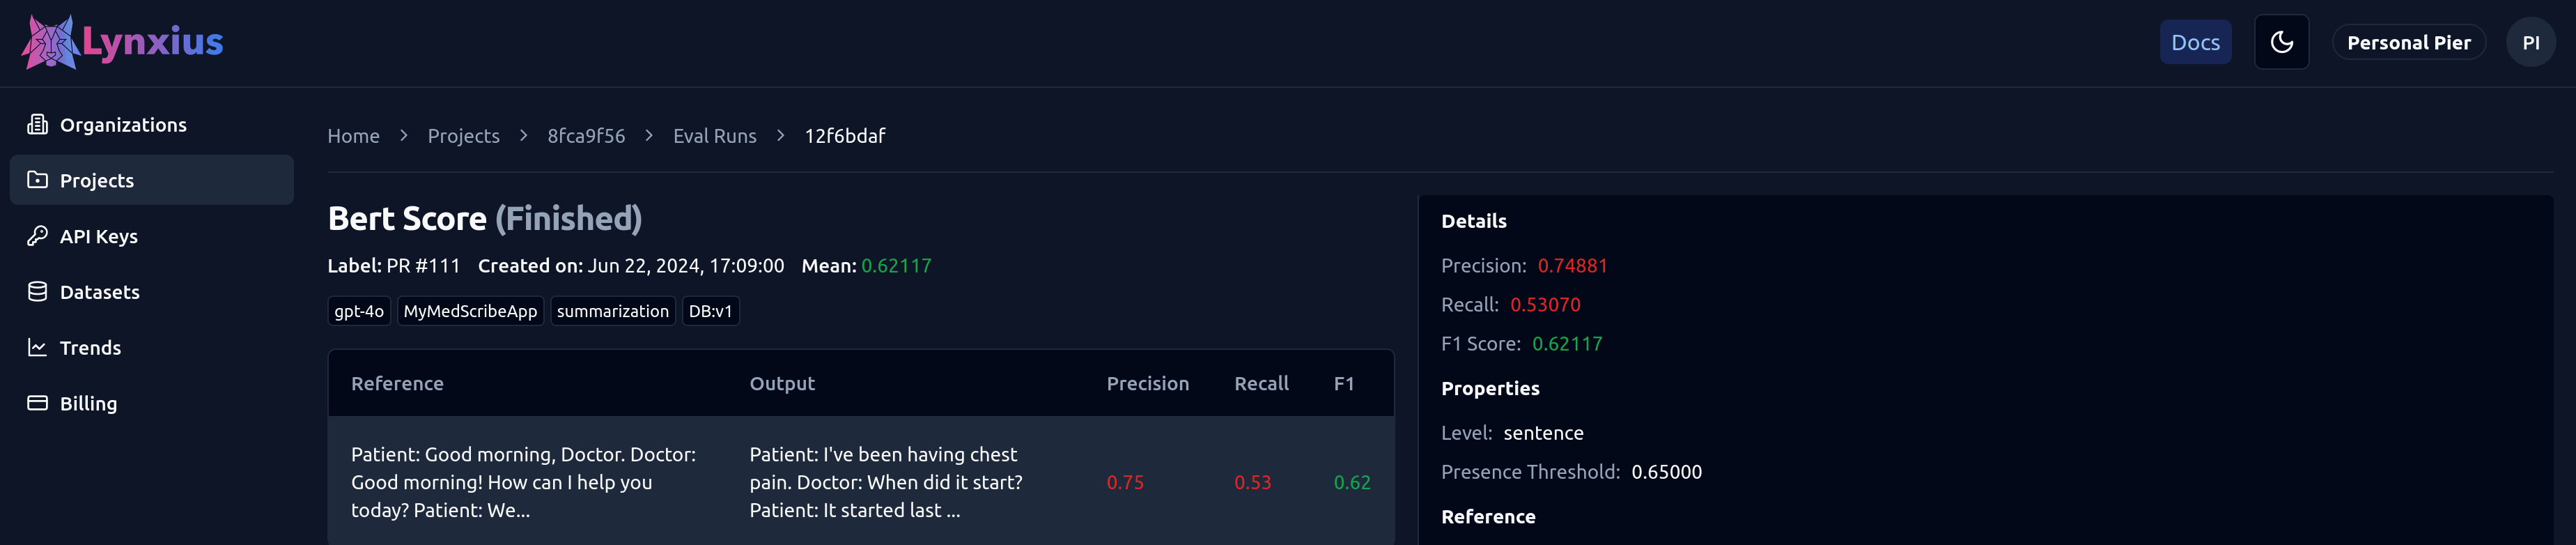

❌❌❌ **Ouch!!! something went wrong** ❌❌❌

Looks like `BERTScore Precision` and `BERTScore Recall` are lower than the 
set threshold. Thankfully `BERTScore` also produce a list of tokens (sentences in our 
case) that are not present in the summary and [Lynxius Platform](platform.lynxius.ai) 
displays it nicely on the side pannel view:

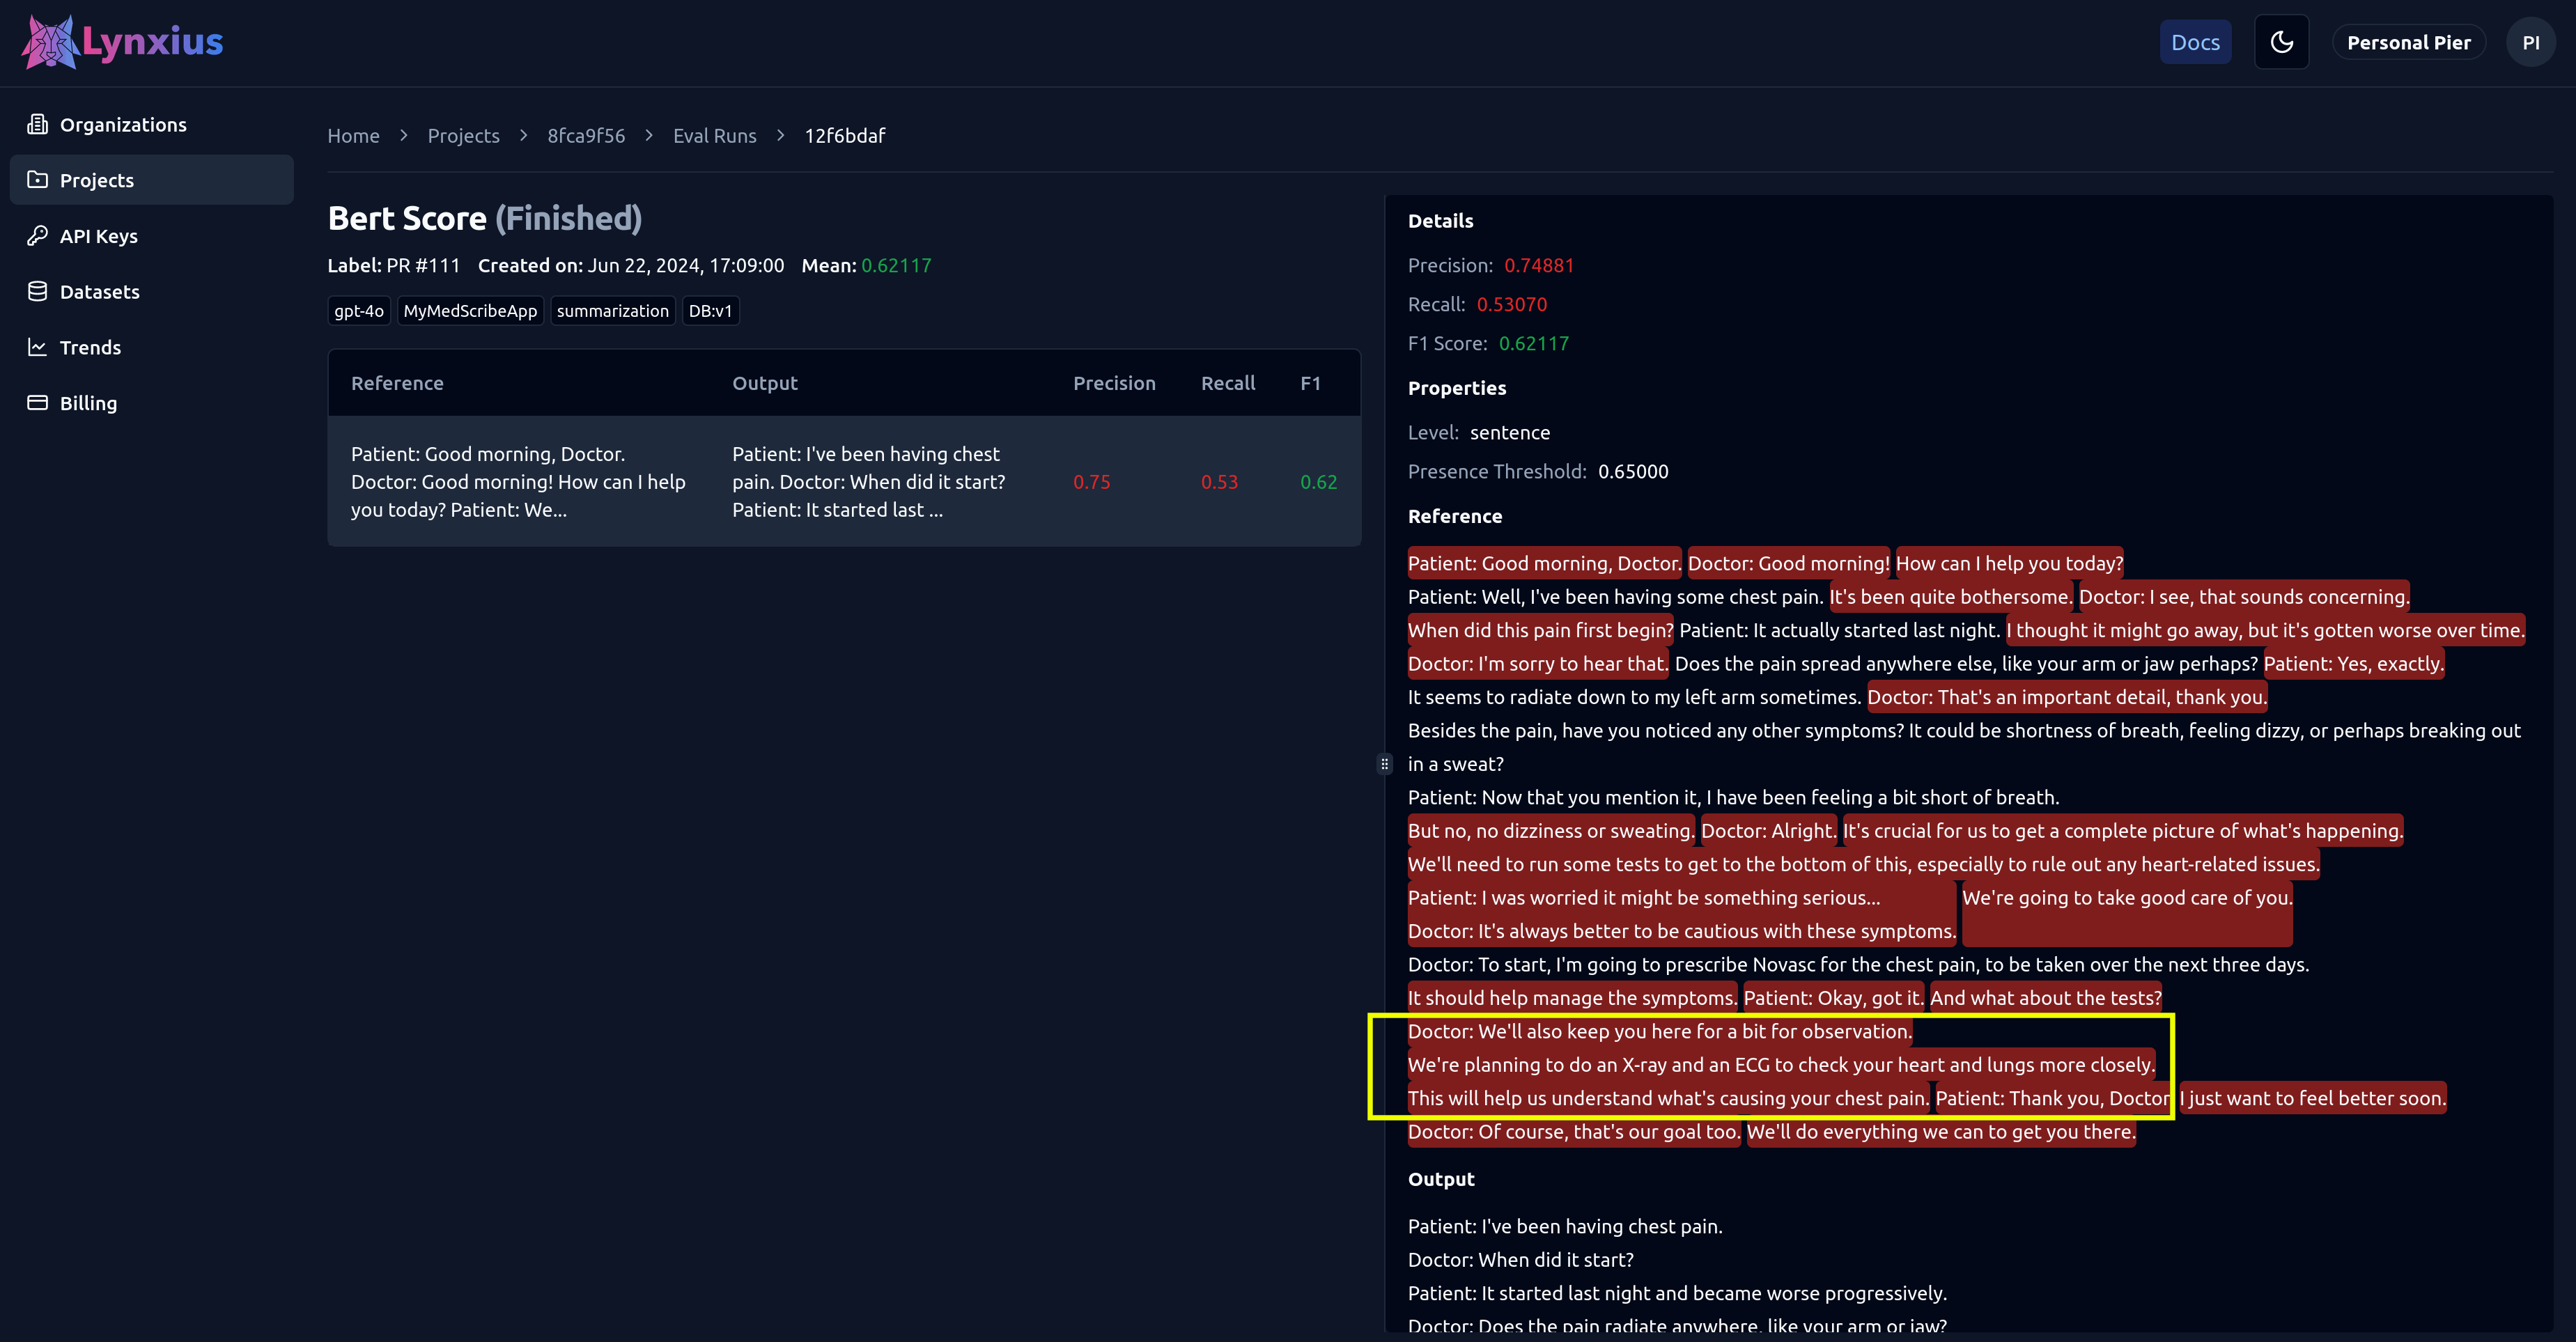

<style>
    @media (prefers-color-scheme: dark) {
        .adaptive-text { background-color: #fc4949; } /* Light text in dark theme */
    }
    @media (prefers-color-scheme: light) {
        .adaptive-text { background-color: #fcbdbd; } /* Dark text in light theme */
    }
</style>

⚠️⚠️⚠️ **Looks like some information was lost during AI-generated summarization** ⚠️⚠️⚠️

The phrase <span class="adaptive-text">We'll also keep you here for a bit for 
observation. We're planning to do an X-ray and an ECG to check your heart and lungs more 
closely. This will help us understand what's causing your chest pain.</span> is pretty 
critical, but isn't in the AI-generated summary.

**MyMedScribe** uses the insights coming from [Lynxius](https://www.lynxius.ai/) to further 
debug and improve their product. After a few days of working **MyMedScribe** team realizes 
that there was a problem with the way they were chunking the script sentences. After 
fixing the issue, they are ready to test again:

In [4]:
# load the new AI-generated summary
new_ai_summary = load_input('./data/AI_medical_scribe_new_summary.yaml')

In [5]:
# Calculate the BertScore and upload results to Lynxius Platform
tags = ["gpt-4o", "MyMedScribeApp", "summarization", "DB:v2"]
bert_score = BertScore("PR #112", level="sentence", presence_threshold=0.65, tags=tags)

# Add traces to the evals
bert_score.add_trace(reference=raw_transcript, output=new_ai_summary, context=[])

# Run eval remotely
client.evaluate(bert_score)

'a2fb4df2-469e-40df-9030-05ae489e52f5'

Let's remember the values of the Bert Score Thresholds set for this project:

<table>
  <thead style="background-color: #919191;">
    <tr>
      <th>Metric</th>
      <th>Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Precision</td>
      <td>0.75</td>
    </tr>
    <tr>
      <td>Recall</td>
      <td>0.56</td>
    </tr>
    <tr>
      <td>F1</td>
      <td>0.66</td>
    </tr>
  </tbody>
</table>


Below a screenshot of the new Bert Score results from [Lynxius Platform](platform.lynxius.ai).

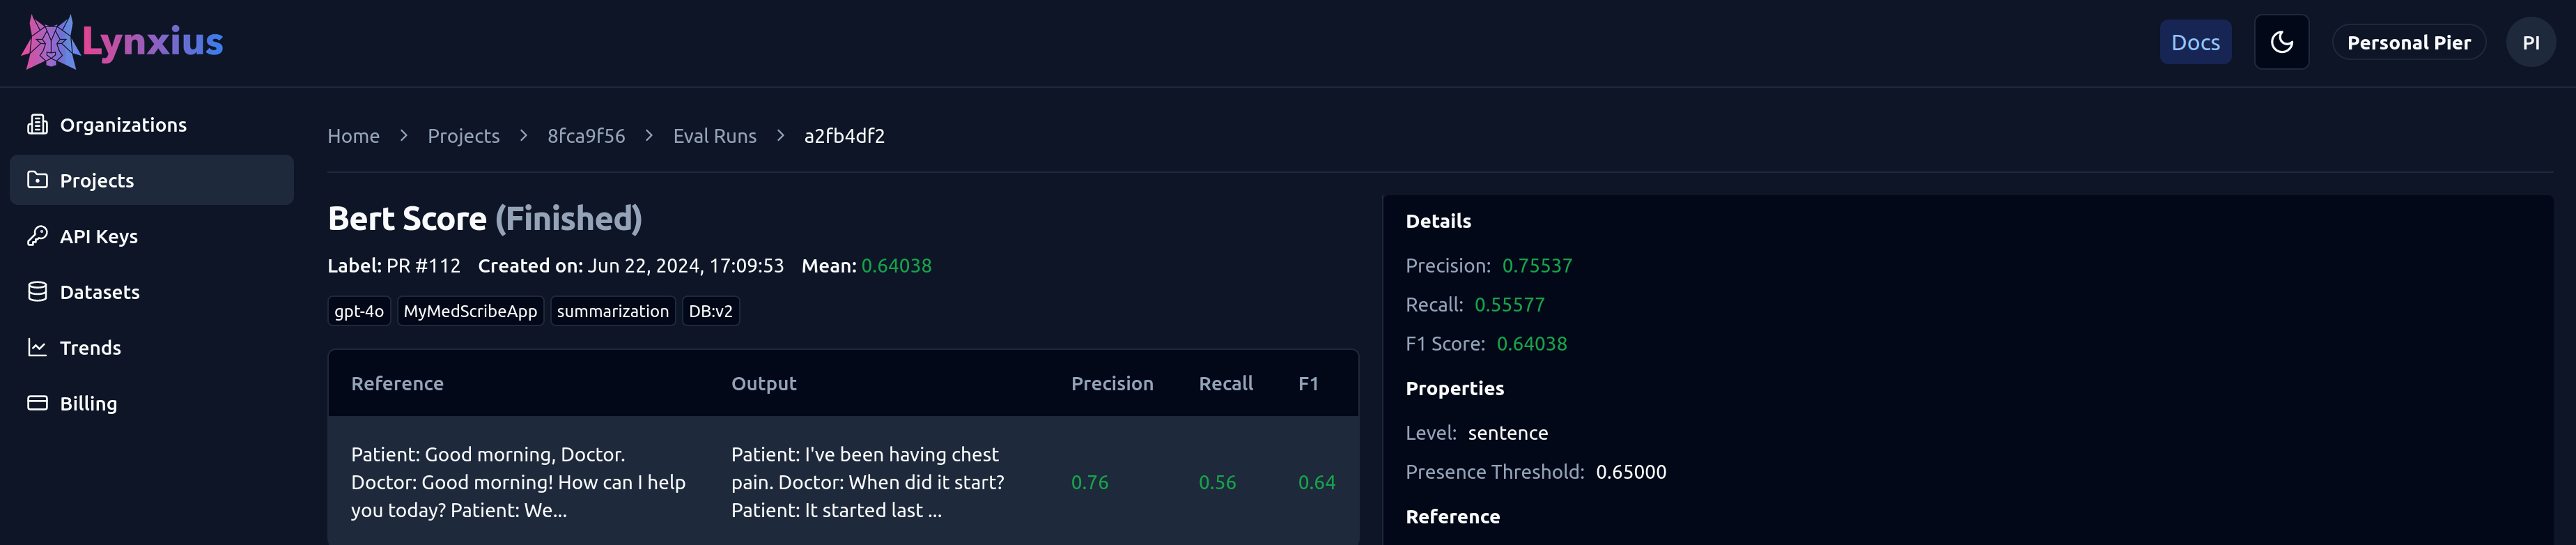

🎉🎉🎉 **Hurray!!!** 🎉🎉🎉

The AI-generated summary is finally accurate ✅✅✅. **MyMedScribe** team now wants 
to evaluate now their App's performance with filing a clinical documentation report.

## Task-2: Evaluating Writing Quality

**MyMedScribe** App uses the new AI-generated summary to generate the clinical 
documentation report.

<img src="https://github-public-assets.s3.us-west-1.amazonaws.com/AI_medical_scribe_clinical_notes_with_error.png" alt="AI Medical Scribe clinical notes with error" width="60%" />

⚠️⚠️⚠️ **The AI-generated clinical documentation looks good, but... How good is it?** ⚠️⚠️⚠️

**MyMedScribe** team knows that Dr. Taylor has to file the clinical documentation 
electronically and share the report with other doctors. The helath of Brenda, as well as 
Dr. Taylor's reputation are at stake. The report must respect all the typical writing 
quality guidelines and must contain all relevant information at the right place. 
**MyMedScribe** team must evaluate their product before and after deploying it to 
production and chooses [Lynxius](https://www.lynxius.ai/) for testing and evaluating 
their LLM App.

### Contains Medication Prescription Evaluator

**MyMedScribe** team wants to make sure that AI-generated  the clinical documentation 
report always contains a drug prescription and that this is always written in a specific 
order: medication, dosage, frequency.

[Lynxius](https://www.lynxius.ai/) provides an easy interface to build use-case specific 
**custom evaluators**. Custom evaluators can be:
* Heuristics
* AI-assisted

In our case, **MyMedScribe** team needs an AI-assisted evaluator. To implement one, they 
only need to create a new prompt that specifies the use-case dependent policy to respect.

<img src="https://github-public-assets.s3.us-west-1.amazonaws.com/AI_medical_scribe_eval_clinical_notes.png" alt="AI Medical Scribe eval clinical notes" width="60%" />

Let's build the `MedicationPrescription` evaluator:

In [6]:
# Building the evaluator prompt template
MEDICATION_PRESCRIPTION_BASE_TEMPLATE = """
You must determine if a given clinical documentation report contains one medication 
prescription, if the medication belongs to the input list of medications, and if the 
medication prescription is written in this order: medication, dosage and frequency of 
use. If all the three conditions are met, the verdict is 'correct'; otherwise, it's 
'incorrect'. Provide a very short explanation about how you arrived to your verdict. 
The verdict must be printed at the very bottom of your response, on a new line, and 
it must not contain any extra characters.
Here is the data:
***********
Clinical Documentation Report: {output}
***********
List of Medications: {medications}
"""

Now that we created the `MedicationPrescription` evaluator, let's use it to assess the 
writing quality of **MyMedScribe** App:

In [7]:
# open AI-generated clinical documentation report and generate reference
ai_clinical_docs = load_yaml_input('./data/AI_medical_scribe_clinical_notes.yaml')

In [8]:
from lynxius.evals.custom_eval import CustomEval

# Calculate the MedicationPrescription and upload results to Lynxius Platform
tags = ["gpt-4o", "MyMedScribeApp", "MedPrescription", "DB:v2"]
custom_eval = CustomEval("PR #111", tags=tags, name="MedicationPrescription", prompt_template=MEDICATION_PRESCRIPTION_BASE_TEMPLATE)

# Add traces to the evals
custom_eval.add_trace(
    values={
        "output": ai_clinical_docs,
        "medications": "[Atorvastatin, Metformin, Amoxicillin, Novasc, Albuterol]"
    }
)

# Run eval remotely
client.evaluate(custom_eval)

'94275186-de28-426b-984e-c4677df260f3'

Below a screenshot of the MedicationPrescription results from [Lynxius Platform](platform.lynxius.ai).

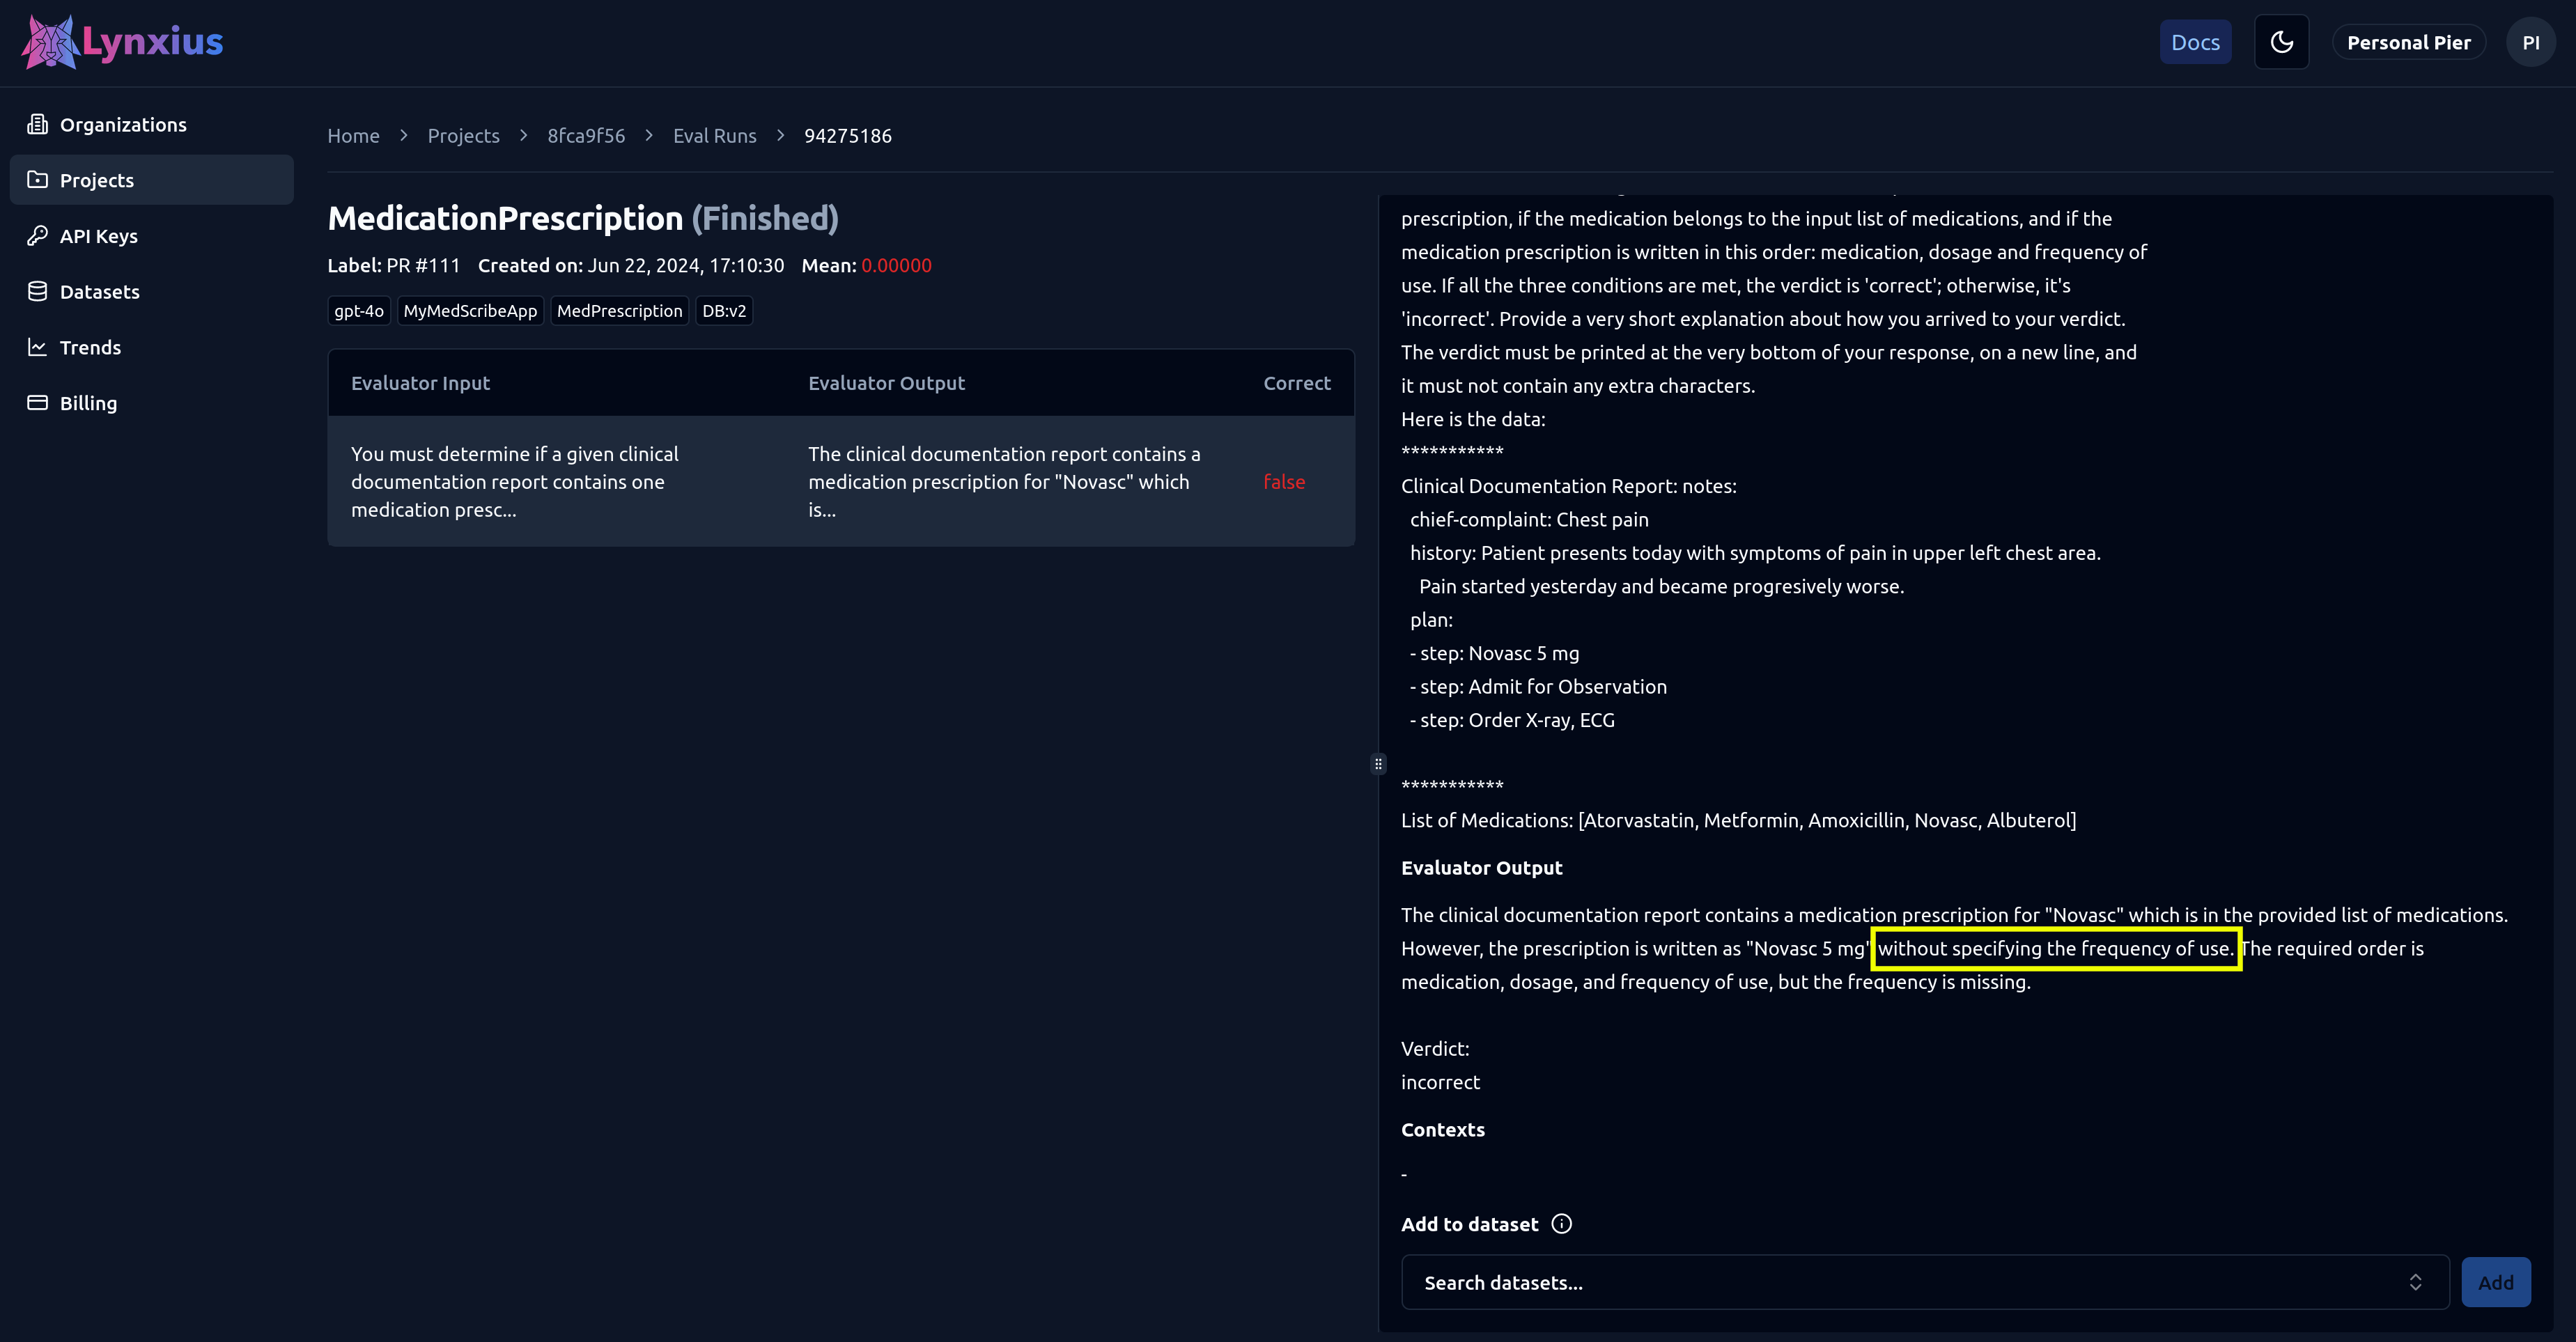

❌❌❌ **Ouch!!! something went wrong** ❌❌❌

It seems like the `MedicationPrescription` is **INCORRECT**. Thankfully 
[Lynxius](https://www.lynxius.ai/) offers an explenation of the error. It seems like the 
prescription does not include the medication's frequency of use.

<img src="https://github-public-assets.s3.us-west-1.amazonaws.com/AI_medical_scribe_clinical_notes_comparison.png" alt="AI Medical Scribe clinical notes comparison" width="60%" />

**MyMedScribe** team uses this insights to improve their product and after a few days of 
working, they fixed the issue and are ready to test again with the newly AI-generated 
clinical documentation report:

In [9]:
# open new AI-generated clinical documentation report and generate reference
new_ai_clinical_docs = load_yaml_input('./data/AI_medical_scribe_new_clinical_notes.yaml')

In [10]:
# Calculate the MedicationPrescription and upload results to Lynxius Platform
tags = ["gpt-4o", "MyMedScribeApp", "MedPrescription", "DB:v3"]
custom_eval = CustomEval("PR #111", tags=tags, name="MedicationPrescription", prompt_template=MEDICATION_PRESCRIPTION_BASE_TEMPLATE)

# Add traces to the evals
custom_eval.add_trace(
    values={
        "output": new_ai_clinical_docs,
        "medications": "[Atorvastatin, Metformin, Amoxicillin, Novasc, Albuterol]"
    }
)

# Run eval remotely
client.evaluate(custom_eval)

'64b1f09c-17ab-4c95-9c2c-fc19219cdbfb'

Below a screenshot of the new MedicationPrescription results from [Lynxius Platform](platform.lynxius.ai).

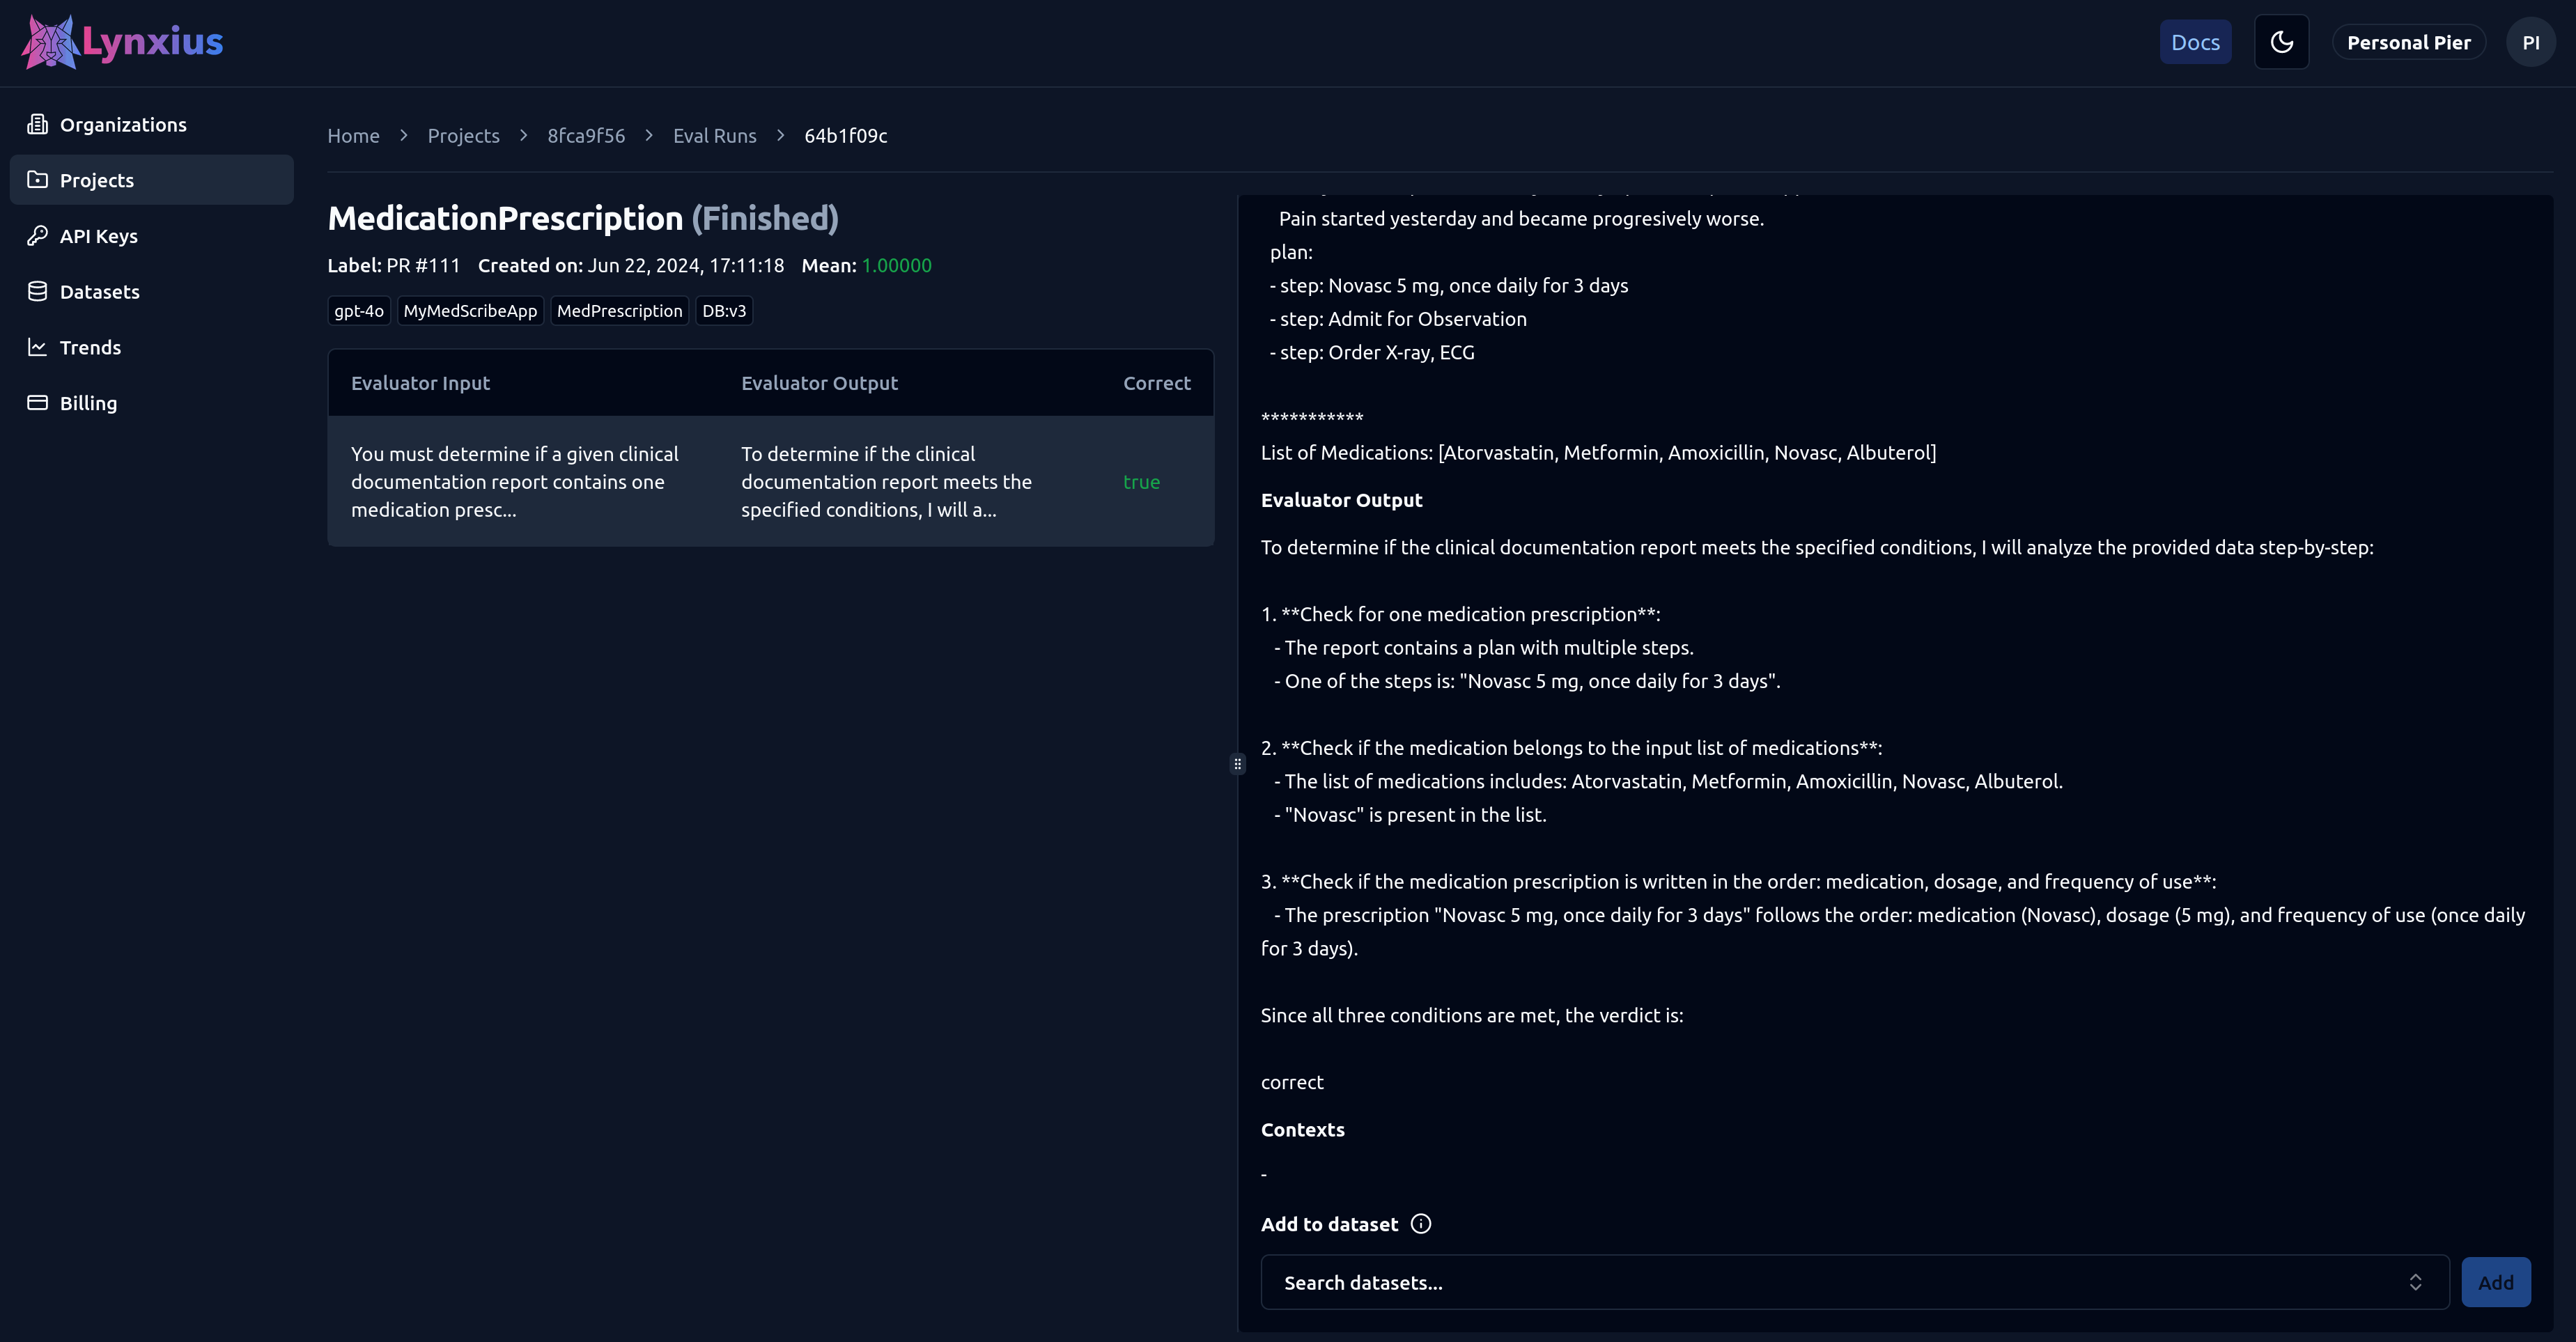

🎉🎉🎉 Hurray!!! 🎉🎉🎉

The clinical documentation report is finally accurate ✅✅✅. **MyMedScribe** team can 
finally deploy the newest version of their LLM App to production 🛠️🛠️🛠️ They can also 
keep using `BERTScore` and `MedicationPrescription` and many more 
[Lynxius](https://www.lynxius.ai/) evaluators to monitor the production behaviour of 
their product.